In [1]:
import pandas as pd


from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import PartialDependenceDisplay
import shap


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Processing incidents data

Aggregate the incidents data into grids with side lengths of 500m and calculate the centroid of each grid. Calculate the response time of each event. The definition of response time here is reaction seconds plus driving seconds according to the requirements.

In [2]:
incidents = pd.read_csv('Data/WMFS_datasets/wmfs_incidents.csv')
# Only pay attention to incidents of type 'FIRE' and 'FALSE_ALARM'
incidents = incidents[incidents['incident_classification_level1'].isin(['FIRE', 'FALSE_ALARM'])]

### If only focus on the data in 2018 and 2019, uncomment these lines
# incidents['call_time'] = pd.to_datetime(incidents['call_time'])
# incidents = incidents[(incidents['call_time'].dt.year == 2018) | (incidents['call_time'].dt.year == 2019)]

incidents = incidents.reset_index(drop=True)

In [3]:
### Aggregate the data into grids
# Define the grid size
grid_size = 500

# Calculate the bound
xmin = incidents['EASTINGS'].min() // grid_size * grid_size # // means quotient rounding
xmax = incidents['EASTINGS'].max() // grid_size * grid_size + grid_size # rounding down so another grid needs to be added
ymin = incidents['NORTHINGS'].min() // grid_size * grid_size
ymax = incidents['NORTHINGS'].max() // grid_size * grid_size + grid_size
# Caculate the grid index
incidents['grid_x'] = ((incidents['EASTINGS'] - xmin) // grid_size).astype(int)
incidents['grid_y'] = ((incidents['NORTHINGS'] - ymin) // grid_size).astype(int)

# Add a grid_id to each incident and fire station
incidents['grid_id'] = incidents['grid_x'].astype(str) + "_" + incidents['grid_y'].astype(str)

In [4]:
# Define 'total response time'
incidents['total_response_time'] = incidents['reaction_seconds'] + incidents['driving_seconds']
incidents

,call_time,incident_classification_label,incident_profile_label,incident_classification_level1,prl_count,brv_count,EASTINGS,NORTHINGS,call_seconds,reaction_seconds,driving_seconds,grid_x,grid_y,grid_id,total_response_time
0,2009/1/1 0:00,False alarm raised with good intent,False Alarms,FALSE_ALARM,2,0,392062.1020,286844.9690,86,160,250,12,29,12_29,410
1,2009/1/1 0:10,Secondary fire,Secondary Fires that attract a 20 minute-respo...,FIRE,1,0,405643.1494,277939.9802,85,65,239,39,11,39_11,304
2,2009/1/1 0:11,False alarm raised with malicious intent,False Alarms,FALSE_ALARM,1,0,410260.2444,288819.1894,62,106,115,48,33,48_33,221
3,2009/1/1 0:53,Secondary fire,Secondary Fires that attract a 20 minute-respo...,FIRE,1,0,396779.2503,299030.1061,72,109,96,21,54,21_54,205
4,2009/1/1 0:52,False alarm raised with malicious intent,False Alarms,FALSE_ALARM,1,0,410667.9614,290492.4786,68,109,204,49,36,49_36,313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292692,2023/12/31 22:59,False Alarms (Equipment),Low Risk,FALSE_ALARM,2,0,398666.6867,283225.4570,88,82,281,25,22,25_22,363
292693,2023/12/31 23:11,False alarm raised with good intent,False Alarms,FALSE_ALARM,1,1,433136.8678,277909.0307,134,94,98,94,11,94_11,192
292694,2023/12/31 23:32,Accidental secondary fire,Secondary Fires that attract a 20 minute-respo...,FIRE,0,1,401134.3304,277356.6820,136,152,227,30,10,30_10,379
292695,2023/12/31 23:49,False Alarms (Equipment),Low Risk,FALSE_ALARM,0,1,406221.0587,290654.1816,253,66,297,40,37,40_37,363


### 2. Processing feature data

In [5]:
# Load the feature dataset
dataset = pd.read_csv('Data/dataset_no_land.csv')

In [6]:
# Load the land cover data into a dictionary
land_cover_files = {
    'verisk': 'Data/land_cover/results/land_verisk.csv', # verisk land cover 2023
    'global': 'Data/land_cover/results/land_global.csv', # global land cover 2019
    'corine_1': 'Data/land_cover/results/land_corine_1.csv', # corine land cover 1 2018
    'corine_2': 'Data/land_cover/results/land_corine_2.csv', # corine land cover 2 2018
    'CLC': 'Data/land_cover/results/land_CLC.csv' # CLC+ land cover 2018
}

In [7]:
# Function to merge the feature dataset with the chosen land cover dataset
def process_with_land_cover(dataset, land_cover_key):
    land_cover = pd.read_csv(land_cover_files[land_cover_key])  # Load selected land cover data
    merged_dataset = pd.merge(dataset, land_cover, on='grid_id', how='left')  # Merge datasets
    return merged_dataset

In [8]:
'''
Options: 'verisk', 'global', 'corine_1', 'corine_2, 'CLC'
'''
selected_land_cover = 'corine_1'
final_dataset = process_with_land_cover(dataset, selected_land_cover)
final_dataset

,grid_id,median,percentile_90,"Accommodation, eating and drinking",Attractions,Commercial services,Education and health,Manufacturing and production,Public infrastructure,Retail,...,node_count,connectivity,road_length,nearest_station_distance,neighbour_frequency_per_month,station_count,Agricultural areas,Artificial surfaces,Forest and semi natural areas,Water bodies
0,0_51,399.0,399.0,0,0,0,0,0,0,0,...,0,1.681265,353.287313,3187.918600,0.177778,5,100.000000,0.000000,0.0,0.0
1,0_52,444.0,622.6,0,0,0,1,0,1,0,...,7,1.571429,1328.092389,2841.271722,0.194444,5,68.929306,31.070694,0.0,0.0
2,0_53,437.5,520.9,0,1,0,1,1,1,0,...,1,3.000000,768.983971,2546.139234,0.188889,5,56.548633,43.451367,0.0,0.0
3,100_10,391.0,575.0,0,2,1,2,0,4,0,...,11,1.545455,734.304719,1571.100570,5.922222,4,94.937310,5.062690,0.0,0.0
4,100_11,294.0,526.8,0,1,3,0,0,1,0,...,20,1.800000,2987.218972,1130.202194,3.855556,4,47.371040,52.628960,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3729,9_59,419.0,657.0,0,0,2,1,1,1,1,...,11,1.818182,2006.875970,2561.426360,1.627778,6,0.000000,100.000000,0.0,0.0
3730,9_60,387.5,531.7,0,0,13,2,2,3,2,...,21,1.619048,2732.349447,2808.541436,2.211111,6,0.000000,100.000000,0.0,0.0
3731,9_61,405.0,525.8,0,1,1,1,0,5,0,...,8,2.000000,1543.196315,3116.874236,2.677778,6,0.000000,100.000000,0.0,0.0
3732,9_62,403.0,507.4,3,1,4,0,0,5,1,...,20,1.550000,2025.332899,3470.144810,2.005556,6,0.000000,100.000000,0.0,0.0


### 3. Processing grids with insufficient data

First, count how many data are in each grid for further analysis later.

In [9]:
grid_grouped = incidents.groupby('grid_id').size()
grid = grid_grouped.reset_index(name='fire_count')
grid

,grid_id,fire_count
0,0_51,1
1,0_52,10
2,0_53,4
3,100_10,131
4,100_11,103
...,...,...
3729,9_59,27
3730,9_60,42
3731,9_61,63
3732,9_62,59


For grids with less than or equal to 3 data, we regard it as insufficient data.

In [10]:
grid_drop = grid[(grid['fire_count'] == 1) | (grid['fire_count'] == 2) | (grid['fire_count'] == 3)]
grid_drop

,grid_id,fire_count
0,0_51,1
18,100_25,3
57,102_7,1
87,104_22,3
89,105_10,1
...,...,...
3623,96_6,3
3643,97_6,1
3663,98_6,3
3687,9_17,2


 If the data from these grids is used directly to build a model, it will have a certain impact on the accuracy. So we use 3 methods to process these data. 
1. **None**: No processing, just use the original data

2. **Delete**: Exclude these grids with insufficient data

3. **Interpolation**: Find num_similar grids that are similar to them, retain the data of the original grid, and use the average value to interpolate

In [11]:
# Define the function to handle insufficient data
def handle_insufficient_data(method, dataset, target_column, features_columns, grid_column='grid_id', num_similar=3):
    """
    Handle insufficient data with three methods:
    1. 'None' - Do not process the insufficient data.
    2. 'Drop' - Remove grids with insufficient data.
    3. 'Interpolation' - Use interpolation to fill in missing data.
    """
    
    # Method 1: Do not process
    if method == 'None':
        # Return features and target unchanged
        X = dataset[features_columns]
        y = dataset[target_column]
        return X, y
    
    # Method 2: Remove grids with insufficient data
    elif method == 'Drop':
        # Filter out rows with insufficient data
        filtered_dataset = dataset[~dataset[grid_column].isin(grid_drop[grid_column])]
        X = filtered_dataset[features_columns]
        y = filtered_dataset[target_column]
        return X, y
    
    # Method 3: Interpolation
    elif method == 'Interpolation':
        grid_drop_df = dataset[dataset[grid_column].isin(grid_drop[grid_column])]
        
        # Caculate cosine similarity
        def calculate_cosine_similarity(target_grid, all_grids, features_columns):
            
            target_vector = [target_grid[features_columns].values]
            all_vectors = all_grids[features_columns].values
            
            return cosine_similarity(target_vector, all_vectors).flatten()
        
        
        # Interpolation
        def interpolate_target(target_grid, similar_grids, num_similar):
            
            similar_grids_sorted = similar_grids.sort_values('similarity', ascending=False).head(num_similar)
            # combine the original median with the median values of the similar grids
            combined_y = np.append(similar_grids_sorted[target_column], target_grid[target_column])
    
            # calculate the average value
            average_y = combined_y.mean()
    
            return average_y
        
        # Apply to grid_drop_df
        def process_grid_interpolation(final_dataset, grid_drop_df, features_columns, num_similar):
            
            # Copy the target column for updates
            y_column = final_dataset[target_column].copy()
            
            for index, row in grid_drop_df.iterrows():
                # Calculate cosine similarity
                similarities = calculate_cosine_similarity(row, final_dataset, features_columns)
                similar_grids = y_column.to_frame()
                similar_grids['similarity'] = similarities
                
                # Exclude the current grid and grids with insufficient data
                similar_grids = similar_grids[similar_grids.index != row.name]
                similar_grids = similar_grids.drop(grid_drop_df.index, errors='ignore')
                
                # Interpolate the target value
                y_column.at[index] = interpolate_target(row, similar_grids, num_similar)
                
            return y_column
        
        
        # Interpolate the target column
        y = process_grid_interpolation(dataset, grid_drop_df, features_columns, num_similar)
        X = dataset[features_columns]
        return X, y



In [12]:
# Define feature columns and dynamically select target column
features_columns = final_dataset.drop(columns=['median', 'percentile_90', 'grid_id']).columns.tolist()

'''
Options: 'median', 'percentile_90'
'''
target_column = 'median'

# Select the method for handling insufficient data
'''
Options: 'None', 'Drop', 'Interpolation'
'''
method = 'Interpolation'

In [13]:
# Calculate the corresponding X and y through the function
X, y = handle_insufficient_data(
    method = method,
    dataset = final_dataset,
    target_column = target_column,
    features_columns = features_columns,
    grid_column = 'grid_id'
)

In [14]:
# Check the updated results if using 'Interpolation'
final_dataset_sorted = final_dataset.sort_index()
y_sorted = y.sort_index()
comparison = final_dataset_sorted[target_column] != y_sorted
print("Number of differences:", comparison.sum())

Number of differences: 411


### 4. Modelling

#### Lasso regression

Lasso regression itself has the  ability of selecting important features, so it can be used directly. First, we need to initialize the intercept and add a constant to each set of data.

In [15]:
X_regression = sm.add_constant(X)

In [16]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_regression, y, test_size=0.2, random_state=0)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the Lasso model with cross-validation to find the best lambda (alpha)
lasso = LassoCV(cv=5, random_state=0)
lasso.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = lasso.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'R²: {r2}')
print(f'Best lambda (alpha): {lasso.alpha_}')

MSE: 3534.2821383268624
R²: 0.7663045571963532
Best lambda (alpha): 0.10372305242028328


In [17]:
### Show coefficients for each feature and sort from high to low absolute value
coefficients = lasso.coef_

# Combine feature names with their corresponding coefficients
feature_names = X_regression.columns
coefficients_dict = {name: coef for name, coef in zip(feature_names, coefficients)}

# Sort the features by the absolute value of their coefficients in descending order
sorted_coefficients = dict(sorted(coefficients_dict.items(), key=lambda item: abs(item[1]), reverse=True))

# Print the sorted feature names and their coefficients
for feature, coef in sorted_coefficients.items():
    print(f"{feature}: {coef}")

nearest_station_distance: 81.57348947955232
Artificial surfaces: -16.676032357658013
neighbour_frequency_per_month: -10.271110149140155
above_65: -10.155875043258765
IMD: -5.68749056717126
road_length: -4.58564764737046
station_count: 4.229320642264109
total_rent: 4.183048467517125
Education and health: -3.7460192218486066
connectivity: -3.7165403502268712
below_14: 2.6948217612096803
Public infrastructure: -2.556931383048683
Forest and semi natural areas: 2.3183961720126174
Sport and entertainment: -2.237226114634013
Retail: 1.923413020417153
Attractions: 1.7925865942190162
Manufacturing and production: -1.6613633412611393
Accommodation, eating and drinking: 1.4503262358240532
Commercial services: 1.2120890483342583
building_count: -1.053811392718428
Transport: -0.7443469681129447
Water bodies: -0.15152511436257088
const: 0.0
node_count: -0.0
Agricultural areas: 0.0


#### Tree-based model

##### I. Feature selection


First, use random forest to select important features.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# select the features using random forest
rf = RandomForestRegressor(n_estimators=100, random_state=0)
rf.fit(X_train, y_train)

selector = SelectFromModel(rf, threshold='median')
selector.fit(X_train, y_train)

X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

In [30]:
# the value of feature importance
feature_importances = rf.feature_importances_
selected_features_mask = selector.get_support()

# get the feature importance
selected_feature_importances = feature_importances[selected_features_mask]

selected_feature_indices = np.where(selected_features_mask)[0]
selected_feature_names = np.array(X.columns)[selected_feature_indices]

sorted_indices = np.argsort(selected_feature_importances)[::-1]
sorted_importances = selected_feature_importances[sorted_indices]
sorted_feature_names = selected_feature_names[sorted_indices]

# print the selected features and their importance
for name, importance in zip(sorted_feature_names, sorted_importances):
    print(f"Name: {name}, Importance: {importance}")

Name: nearest_station_distance, Importance: 0.6456623754955758
Name: neighbour_frequency_per_month, Importance: 0.17321816200192305
Name: below_14, Importance: 0.021277039134290326
Name: road_length, Importance: 0.0196974926061004
Name: above_65, Importance: 0.01463205609845586
Name: total_rent, Importance: 0.014600111042507297
Name: IMD, Importance: 0.013560881429045086
Name: building_count, Importance: 0.012981008214945492
Name: connectivity, Importance: 0.012435273853077649
Name: station_count, Importance: 0.011413497914044614
Name: Artificial surfaces, Importance: 0.008652945702732338
Name: node_count, Importance: 0.007805786981597861


##### II. Random Forest regression

For Random Forest, we perform a grid search on the number of trees *(n_estimators)*, the depth of the maximum tree *(max_depth)* and the minimum number of leaf node samples *(min_samples_split)*.

In [33]:
### Random forest regression
# Tuning the hyperparameters using grid search with cross validation
rf_hyperparameters = {
    'n_estimators': [250, 300, 350],
    'max_depth': [8, 10, 12],
    'min_samples_split': [8, 10, 12, 15]
}

rf = RandomForestRegressor(random_state=0)
rf_grid_search = GridSearchCV(estimator=rf, param_grid=rf_hyperparameters, cv=5, n_jobs=-1, verbose=2)

# Train the model
rf_grid_search.fit(X_train_selected, y_train)

# Extract the best hyperparameters
rf_best_params = rf_grid_search.best_params_
rf_best_params

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END .max_depth=8, min_samples_split=8, n_estimators=250; total time=   6.1s
[CV] END .max_depth=8, min_samples_split=8, n_estimators=250; total time=   6.1s
[CV] END .max_depth=8, min_samples_split=8, n_estimators=250; total time=   6.1s
[CV] END .max_depth=8, min_samples_split=8, n_estimators=250; total time=   6.1s
[CV] END .max_depth=8, min_samples_split=8, n_estimators=250; total time=   6.3s
[CV] END .max_depth=8, min_samples_split=8, n_estimators=300; total time=   7.4s
[CV] END .max_depth=8, min_samples_split=8, n_estimators=300; total time=   7.4s
[CV] END .max_depth=8, min_samples_split=8, n_estimators=300; total time=   7.5s
[CV] END .max_depth=8, min_samples_split=8, n_estimators=300; total time=   7.9s
[CV] END .max_depth=8, min_samples_split=8, n_estimators=300; total time=   8.0s
[CV] END .max_depth=8, min_samples_split=8, n_estimators=350; total time=   9.1s
[CV] END .max_depth=8, min_samples_split=8, n_e

{'max_depth': 8, 'min_samples_split': 15, 'n_estimators': 350}

In [35]:
rf_model = RandomForestRegressor(
    n_estimators=rf_best_params['n_estimators'],
    max_depth=rf_best_params['max_depth'],
    min_samples_split=rf_best_params['min_samples_split'],
    random_state=0)

rf_model.fit(X_train_selected, y_train)
y_pred_rf = rf_model.predict(X_test_selected)

print(f'Random Forest MSE: {mean_squared_error(y_test, y_pred_rf)}')
print(f'Random Forest R²: {r2_score(y_test, y_pred_rf)}')

Random Forest MSE: 3043.2037814651057
Random Forest R²: 0.7987758680782922


##### III. XGBoost

For XGBoost, we perform a grid search on the number of trees *(n_estimators)*, the depth of the maximum tree *(max_depth)*, the minimum number of leaf node samples *(min_samples_split)*, the sample sampling ratio *(subsample)* and the feature sampling ratio *(colsample_bytree)*.

In [37]:
# Tuning the hyperparameters using grid search with cross validation
xgb_hyperparameters = {
    'n_estimators': [300, 400, 500],      
    'max_depth': [4, 5, 6],            
    'learning_rate': [0.005, 0.01, 0.02], 
    'subsample': [0.8],
    'colsample_bytree': [1] 
}

xgb = XGBRegressor(random_state=0)

# Train the model
xgb_grid_search = GridSearchCV(estimator=xgb, param_grid=xgb_hyperparameters, cv=5, n_jobs=-1, verbose=2)
xgb_grid_search.fit(X_train, y_train)

# Extract the best hyperparameters
xgb_best_params = xgb_grid_search.best_params_
xgb_best_params

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END colsample_bytree=1, learning_rate=0.005, max_depth=4, n_estimators=300, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=1, learning_rate=0.005, max_depth=4, n_estimators=300, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=1, learning_rate=0.005, max_depth=4, n_estimators=300, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=1, learning_rate=0.005, max_depth=4, n_estimators=300, subsample=0.8; total time=   2.0s
[CV] END colsample_bytree=1, learning_rate=0.005, max_depth=4, n_estimators=300, subsample=0.8; total time=   2.0s
[CV] END colsample_bytree=1, learning_rate=0.005, max_depth=4, n_estimators=400, subsample=0.8; total time=   2.4s
[CV] END colsample_bytree=1, learning_rate=0.005, max_depth=4, n_estimators=400, subsample=0.8; total time=   2.5s
[CV] END colsample_bytree=1, learning_rate=0.005, max_depth=4, n_estimators=400, subsample=0.8; total time=   2.5s
[CV] END colsample

{'colsample_bytree': 1,
 'learning_rate': 0.01,
 'max_depth': 5,
 'n_estimators': 400,
 'subsample': 0.8}

In [39]:
# XGBoost regression
xgb_model = XGBRegressor(
    n_estimators=xgb_best_params['n_estimators'],
    max_depth=xgb_best_params['max_depth'],
    learning_rate=xgb_best_params['learning_rate'],
    subsample=xgb_best_params['subsample'],
    colsample_bytree=xgb_best_params['colsample_bytree'],
    random_state=0)
xgb_model.fit(X_train_selected, y_train)
y_pred_xgb = xgb_model.predict(X_test_selected)

print(f'XGBoost MSE: {mean_squared_error(y_test, y_pred_xgb)}')
print(f'XGBoost R²: {r2_score(y_test, y_pred_xgb)}')

XGBoost MSE: 3061.617162814263
XGBoost R²: 0.79755832993632


### 5. Plotting

#### I. Feature importance

Visualize the 5 most important features and their feature importance values ​​from large to small.

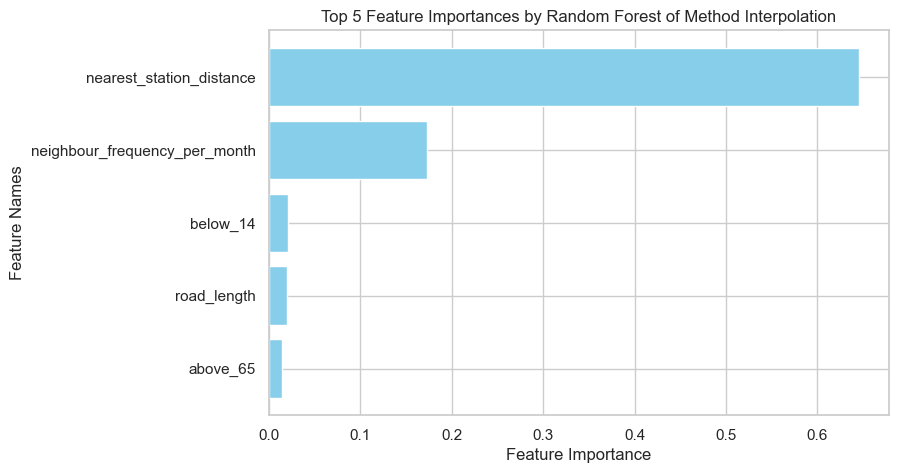

In [49]:
# Select the five most important features
top_n = 5
top_features = sorted_feature_names[:top_n]
top_importances = sorted_importances[:top_n]

plt.figure(figsize=(8, 5))
plt.barh(top_features, top_importances, color="skyblue")
plt.xlabel("Feature Importance")
plt.ylabel("Feature Names")
plt.title(f"Top {top_n} Feature Importances by Random Forest of Method {method}")
plt.gca().invert_yaxis()  # Reverse the y-axis so that the most important features are on top

plt.tight_layout()
plt.show()

#### II. Actual and Predicted value 

Draw a scatter plot. Its x-coordinate is the actual response time and its y-coordinate is the predicted response time, so that we can observe at what value the model prediction performance is better.

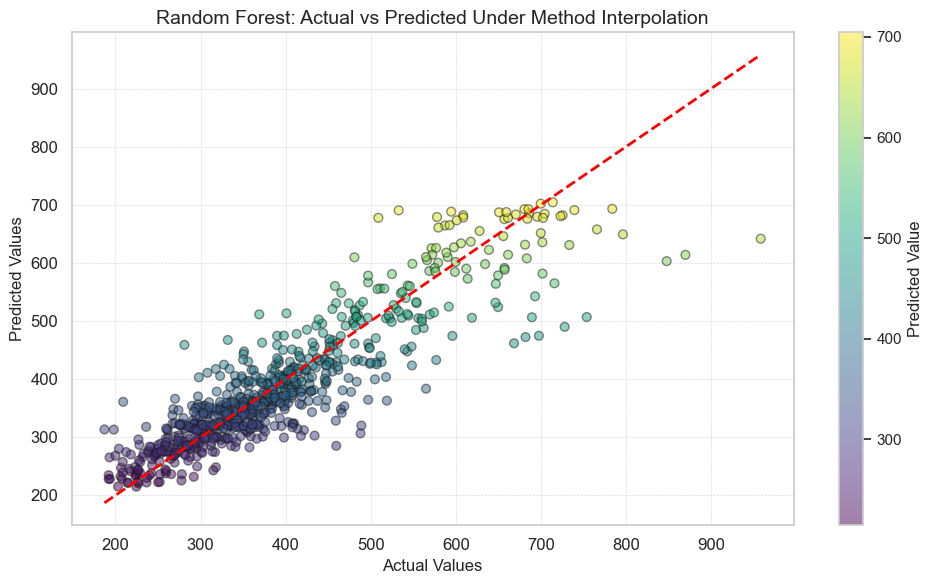

In [58]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5, c=y_pred_rf, cmap='viridis', s=40, edgecolor='k')

# Plot the y=x reference line
max_val = max(max(y_test), max(y_pred_rf))
min_val = min(min(y_test), min(y_pred_rf))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2)

# Add the color bar
plt.colorbar(label='Predicted Value')

# Set x and y axis labels
plt.title(f"Random Forest: Actual vs Predicted Under Method {method}", fontsize=14)
plt.xlabel('Actual Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()


#### III. Partial Dependency Plot

Plot the Partial Dependency Plots of Random Forest and XGBoost separately for the top five most important features.

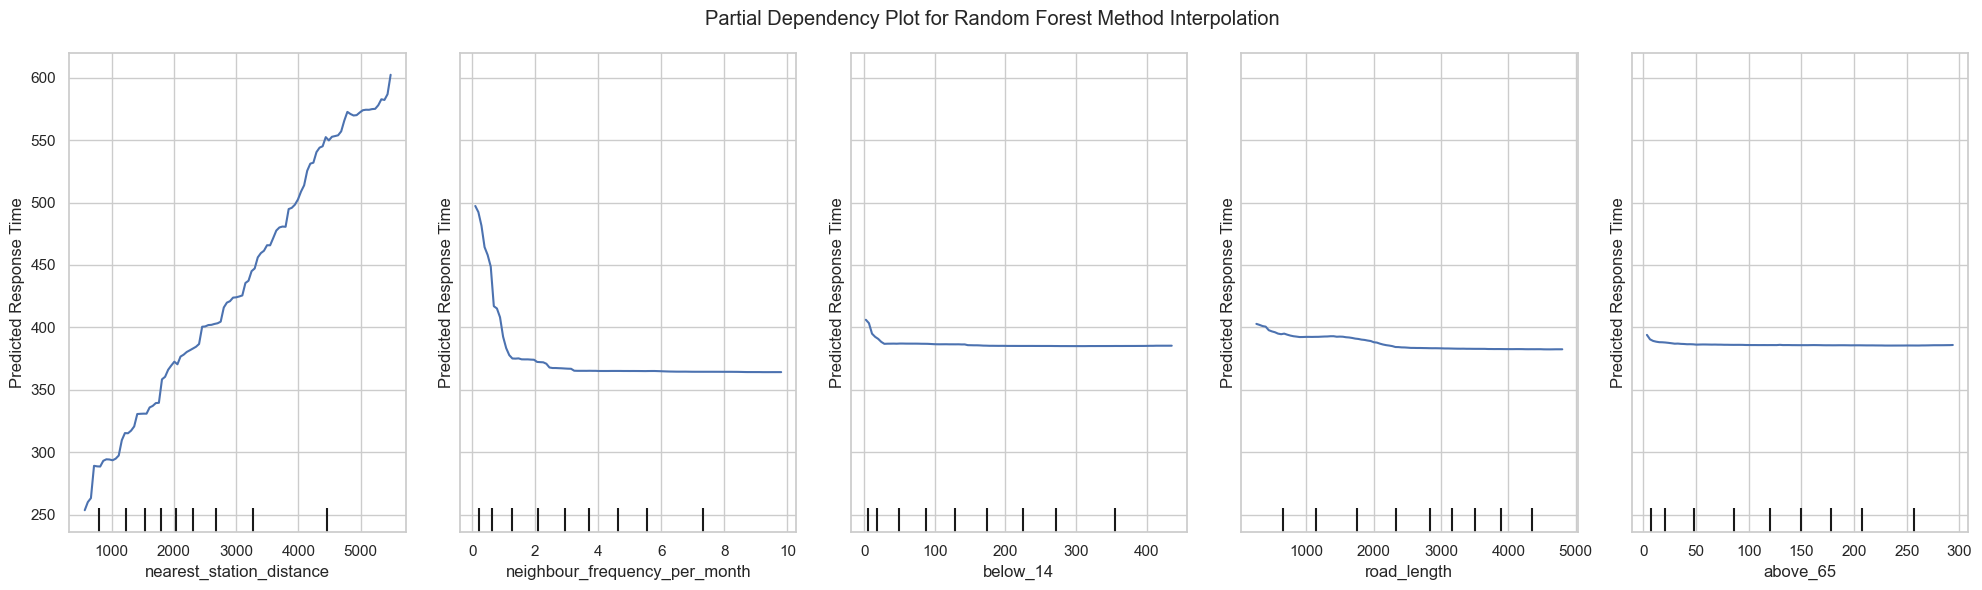

In [61]:
top_n = 5
top_indices = list(sorted_indices)[:top_n]

In [ ]:
### Random Forest
# Create multiple subplots
fig, ax = plt.subplots(1, top_n, figsize=(20, 6), sharey=True)

pdp_display = PartialDependenceDisplay.from_estimator(rf_model, X_test_selected, features=top_indices, ax=ax)

# Set x and y axis labels
for i, axi in enumerate(ax):
    feature_name = sorted_feature_names[i]
    axi.set_xlabel(feature_name)
    axi.set_ylabel('Predicted Response Time')

fig.suptitle(f"Partial Dependency Plot for Random Forest Method {method}")

plt.tight_layout()
plt.show()

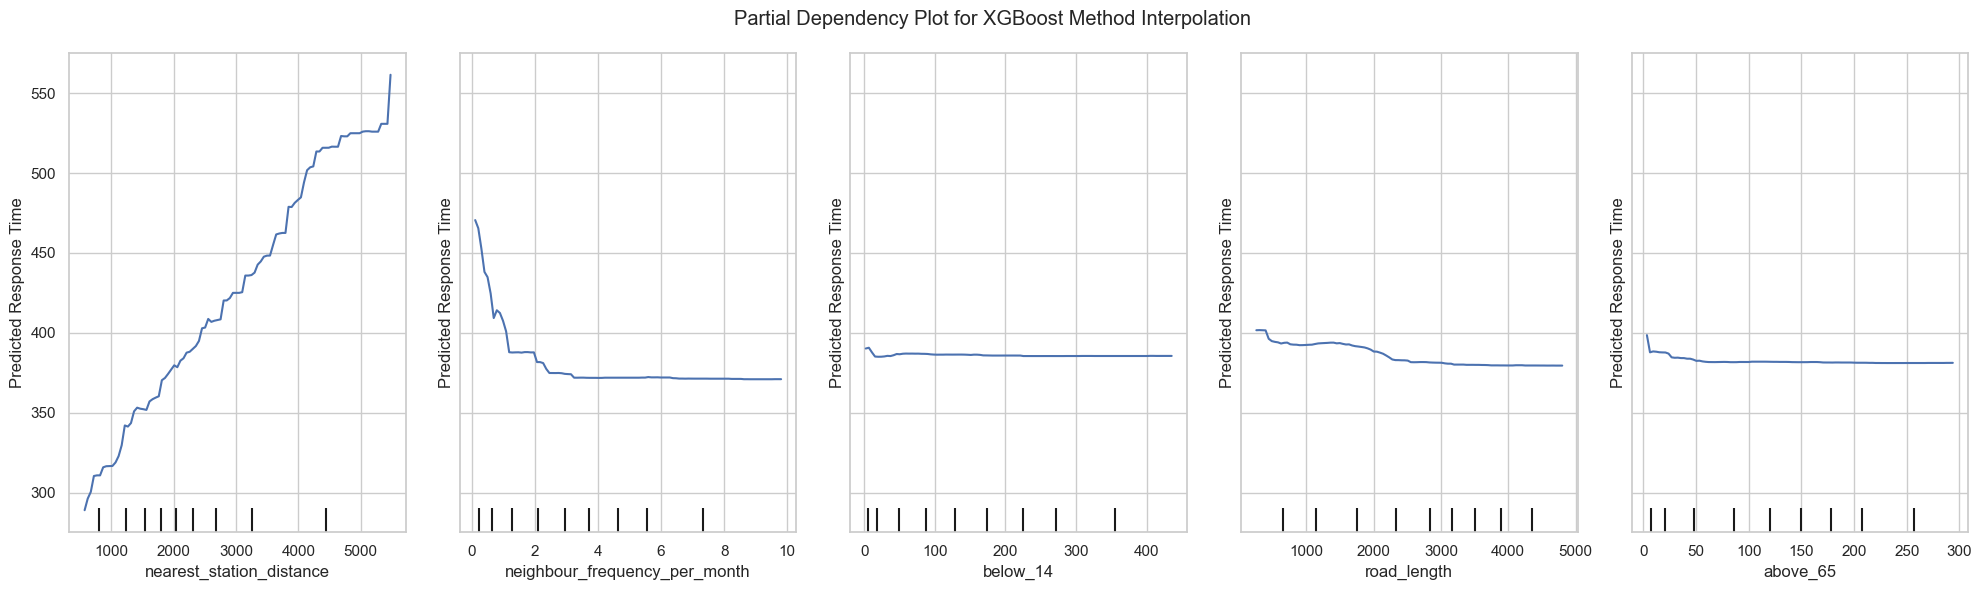

In [62]:
### XGBoost
# Create multiple subplots
fig, ax = plt.subplots(1, top_n, figsize=(20, 6), sharey=True)

pdp_display = PartialDependenceDisplay.from_estimator(xgb_model, X_test_selected, features=top_indices, ax=ax)

# Set x and y axis labels
for i, axi in enumerate(ax):
    feature_name = sorted_feature_names[i]
    axi.set_xlabel(feature_name)
    axi.set_ylabel('Predicted Response Time')

fig.suptitle(f"Partial Dependency Plot for XGBoost Method {method}")

plt.tight_layout()
plt.show()

#### IV. SHAP

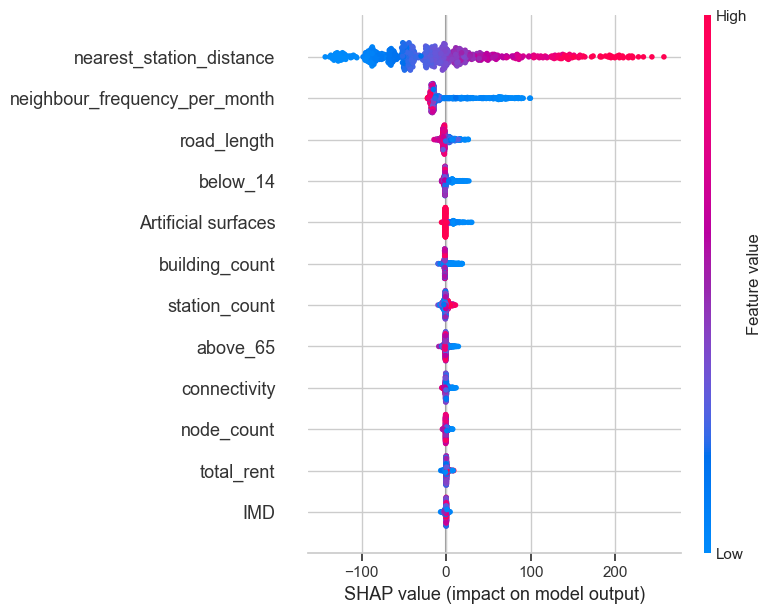

In [64]:
rf_explainer = shap.TreeExplainer(rf_model)
rf_shap_values = rf_explainer.shap_values(X_test_selected)

shap.summary_plot(rf_shap_values, X_test_selected, feature_names=selected_feature_names)

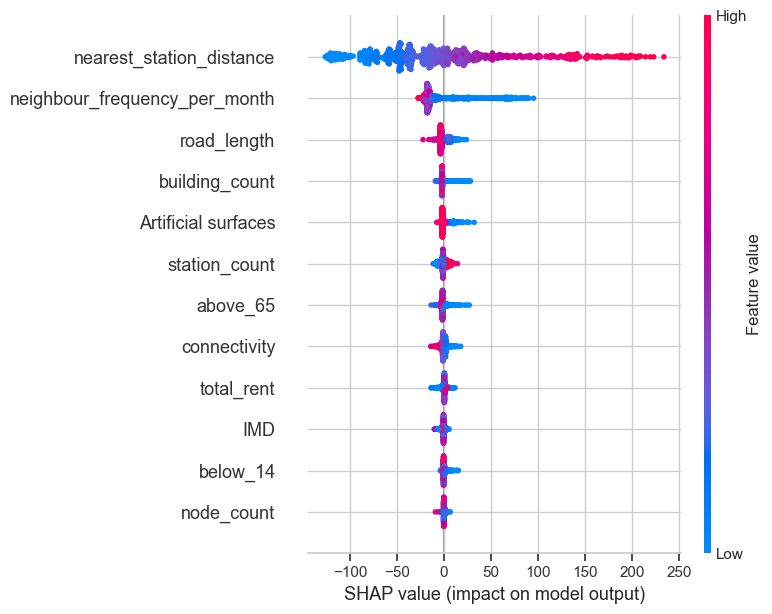

In [65]:
xgb_explainer = shap.TreeExplainer(xgb_model)
xgb_shap_values = xgb_explainer.shap_values(X_test_selected)

shap.summary_plot(xgb_shap_values, X_test_selected, feature_names=selected_feature_names)